# Integrated Model for an Ultra-supercritical Power Plant with Thermal Energy Storage System


Author: Naresh Susarla (naresh.susarla@netl.doe.gov)

This notebook presents an integrated model for the ultra-supercritical power plant with the thermal energy storage (TES) system. The design of TES system and its optimal integration with the ultra-supercritical power plant are studied separately. The optimal solution obtained from the design model is used to develop the integrated model presented in this tutorial. For further details on the ultra-supercritical power plant model and the design of TES system, readers are welcomed to refer to other Jupyter Notebook tutorials included in this repository to specifically describe those problems.

In this notebook, the components for TES implementation are the following: (1) Storage fluid: Solar salt, (2) steam source during charge: HP steam, (3) condensate recycle: Boiler Feed Pump, and (4) condensate source during discharge: Boiler Feed Pump. An overview of the integrated plant flowsheet is shown in the following process flow diagram.

<div>
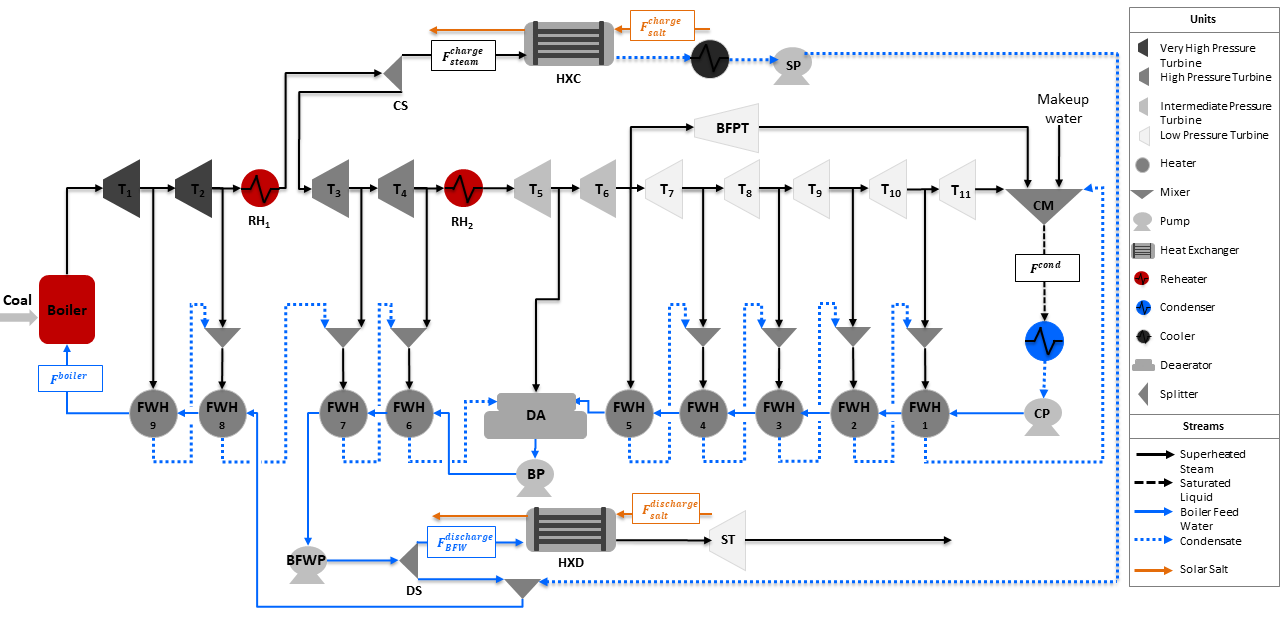
</div>

Note that in this model, both the charge and discharge heat exchangers are included in the same flowsheet.
The integrated model is also constructed using the unit models from the power generation unit model library in addition to the IAPWS property package for steam and water, and the Solar salt property package in the storage heat exchangers. The unit models used are shown in the table below: 

| Unit Model                      | Units in Flowsheet                                                   |
| :---                            | :----                                                                |
|`HelmTurbineStage`               | Turbines (`T_1` to `T_11`) and `BFPT`            |
|`HelmSplitter`                   | Turbine Splitters                                                    |
|`Heater`                         | Boiler Components (`Boiler`, `RH_1`, and `RH_2`)   |
|`HelmMixer`                      | Mixers (`CM` and `DA`)                                   |
|`HelmIsentropicCompresssor`      | Pumps (`CP`, `BP`, `BFWP`, and `SP`)         |
|`HeatExchanger`                  | Condenser, Feed Water Heaters (`FWH_1` to `FWH_9`),      |
|                                 |and Storage Systems (`HXC` and `HXD`)                     |

The integrated ultra-supercritical power plant model has a total of 4 degrees of freedom, listed below:

1) Boiler feed water flow (`boiler.inlet.flow_mol`),

2) Steam flow to charge heat exchanger (`HXC.inlet_1.flow_mol`)

3) Condensate flow to discharge heat exchanger (`HXD.inlet_2.flow_mol`),

4) Cooler enthalpy at outlet (`cooler.outlet.enth_mol`)

To describe the process, first import flowsheet module. The detailed model can be accessed from the Dispatches repository, `integrated_storage_with_ultrasupercritical_power_plant.py`. 

In [1]:
from dispatches.models.fossil_case.ultra_supercritical_plant import (ultra_supercritical_powerplant as usc)
import integrated_storage_with_ultrasupercritical_power_plant as isp
from idaes.core.solvers import get_solver

The integrated model (`isp`) first imports the ultra-supercritical power plant model and then adds all the unit models required for the integration of a TES system (`create_integrated_model`). These unit models are connected using Arcs (`_create_arcs`). Further flowsheet constraints (`_make_constraints`) are added to the model along with model inputs (`set_model_input`), bounds (`add_bounds`) and scaling factors (`set_scaling_factors`) to all variables in the flowsheets. 

The important variables and constraints are described below along with the methods to construct them in the model. Also, note that it is assumed that the power plant alone can produce a maximum power of 436 MW.

### Notable Variables

|Variable Name       |Description                            |
|:---                |:----                                  |
|`PlantPowerOut`     |Power out from the power pant in MW    |
|`Revenue`           |Revenue in $ per hour                  |
|`SaltInventory`     |Total solar salt inventor y in kg      |
|`HotSaltInventory`  |Hot solar salt inventory in kg         |


### Notable Constraints

1) The net power is given by the sum of the power produced by the storage system and the plant as shown in the following equation:

$$
    NetPower = PlantPowerOut + ST.mechanical_{work}
$$

2) The revenue is calculated by considering the given electricity price `lmp_signal` and the amount of net power `NetPower` produced by the plant and the storage system. This is shown in the equation below:

$$
    Revenue = lmp_{signal} * NetPower
$$

3) The salt inventory `SaltInventory` is given by the hot salt and total salt material balances, the latter involving a fixed amount of salt `total_salt`. The material balances are shown in the following equations:

$$
    HotSaltInventory = HotSaltInventory + F^{charge}_{salt, outlet} - F^{discharge}_{salt, inlet}
$$
$$
    total_salt = HotSaltInventory + ColdSaltInventory
$$

In [2]:
# Build the ultra-supercritical power plant model and initialize
max_power = 436

m = usc.build_plant_model()
usc.initialize(m)

# Create the integrated flowsheet, add properties, unit models, and arcs
m = isp.create_integrated_model(m, max_power=max_power)

# Give all the required inputs to the model
isp.set_model_input(m)

# Add scaling factor
isp.set_scaling_factors(m)

# Initialize the model with a sequential initialization and custom
# routines
isp.initialize(m)

# Add cost correlations
m = isp.build_costing(m)

# Initialize with bounds
isp.initialize_with_costing(m)

# Add bounds
isp.add_bounds(m)

2022-06-28 15:58:08 [INFO] idaes.init.fs.boiler.control_volume: Initialization Complete
2022-06-28 15:58:08 [INFO] idaes.init.fs.boiler: Initialization Complete: optimal - Optimal Solution Found
2022-06-28 15:58:08 [INFO] idaes.init.fs.turbine_splitter[1]: Initialization Complete: optimal - Optimal Solution Found
2022-06-28 15:58:09 [INFO] idaes.init.fs.turbine_splitter[2]: Initialization Complete: optimal - Optimal Solution Found
2022-06-28 15:58:09 [INFO] idaes.init.fs.reheater[1].control_volume: Initialization Complete
2022-06-28 15:58:09 [INFO] idaes.init.fs.reheater[1]: Initialization Complete: optimal - Optimal Solution Found
2022-06-28 15:58:09 [INFO] idaes.init.fs.turbine_splitter[3]: Initialization Complete: optimal - Optimal Solution Found
2022-06-28 15:58:09 [INFO] idaes.init.fs.turbine_splitter[4]: Initialization Complete: optimal - Optimal Solution Found
2022-06-28 15:58:09 [INFO] idaes.init.fs.reheater[2].control_volume: Initialization Complete
2022-06-28 15:58:09 [INFO] 

2022-06-28 15:58:18 [INFO] idaes.init.fs.hxd: Initialization Completed, optimal - Optimal Solution Found
Integrated Model Initialization =  optimal
***************   Integrated Model Initialized   ***************
Cost Initialization =  optimal
******************** Costing Initialized *************************




Next, set up the model inputs, fix the degress of freedom, and solve the model using the `model_analysis` method for an initial empty Solar salt tank scenario.

In [3]:
optarg = {"max_iter": 300}
solver = get_solver('ipopt', optarg)

power_demand = 460

# Tank scenarios: "hot_empty", "hot_full", "hot_half_full"
tank_scenario = "hot_empty"

# If hot_empty is selected and fix_power is True
# then ensure that power_demand <= max_power
fix_power = False

isp.model_analysis(m,
                   solver,
                   power=power_demand,
                   max_power=max_power,
                   tank_scenario=tank_scenario,
                   fix_power=fix_power)

Ipopt 3.13.2: nlp_scaling_method=gradient-based
tol=1e-06
max_iter=150
linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection 

Print the charge and discharge heat exchangers report to see the results.

In [4]:
m.fs.hxc.report()
m.fs.hxd.report()


Unit : fs.hxc                                                              Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key            : Value    : Units                           : Fixed : Bounds
           HX Area :   24.708 :                      meter ** 2 : False : (0, 6000)
    HX Coefficient : 0.030095 : kilogram / kelvin / second ** 3 : False : (0, 10000)
         Heat Duty :   27.281 :                            watt : False : (0, 200000000.0)

    Expressions: 

    Key             : Value  : Units
    Delta T Driving : 36.688 : kelvin
         Delta T In : 35.150 : kelvin
        Delta T Out : 38.269 : kelvin

------------------------------------------------------------------------------------
    Stream Table
                                     Units        Hot Inlet  Hot Outlet Cold Inlet Cold Outlet
    Molar Flow (mol/s)              mole / second 0.00063260 0.00063260         